## Image Classification





### Motivation 

Through this assessment, you will gain practical experience in:

> 1. Implementing and evaluating a multi-layer perceptron (MLP) and convolutional neural network (CNN) in solving a classification problem
> 2. Building, evaluating, and finetuning a CNN on an image dataset from development to testing 
> 3. Tackling overfitting using strategies such as data augmentation and drop out
> 4. Fine tuning a model 
> 5. Comparing the performance of a new model with an off-the-shelf model (AlexNet)
> 6. Gaining a deeper understanding of model performance using visualisations from Grad-CAM.


### Setup and resources 

You must work using this template notebook.

Having a GPU will speed up the training process. See the provided document on Minerva about setting up a working environment for various ways to access a GPU. We highly recommend you use platforms such as Colab.

Please implement the coursework using **Python and PyTorch**, and refer to the notebooks and exercises provided.

This coursework will use a subset of images from Tiny ImageNet, which is a subset of the [ImageNet dataset](https://www.image-net.org/update-mar-11-2021.php). Our subset of Tiny ImageNet contains **30 different categories**, we will refer to it as TinyImageNet30. The training set has 450 resized images (64x64 pixels) for each category (13,500 images in total). 



### Required submissions

##### 1. Kaggle Competition
To participate in the submission of test results, you will need an account. Even if you have an existing Kaggle account, please carefully adhere to these instructions, or we may not be able to locate your entries:

> 1. Use your **university email** to register a new account.
> 2. Set your **Kaggle account NAME** to your university username, for example, ``sc15jb``.

The class Kaggle competition also includes a blind test set, which will be used in Question 1 for evaluating your custom model's performance on a test set. The competition website will compute the test set accuracy, as well as position your model on the class leaderboard. [Link to submit your results on Kaggle competition](https://www.kaggle.com/competitions/comp5623m-artificial-intelligence/submissions). 

Please submit only your predictions from test set - detailed instructions are provided in (3)

##### 2. Submission of your work

Please submit the following:

> 1. Your completed Jupyter notebook file, without removing anything in the template, in **.ipynb format.**
> 2. The **.html version** of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) displayed in the .html for marking.
> 3. Your selected images from section 6 "Failure/success analysis" (outputs from gradcam, for example you can put these images into failure and succcess folders).

**Final note:**

> **Please display everything that you would like to be marked. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.


## Required packages

[1] [numpy](http://www.numpy.org) is a package for scientific computing with python

[2] [h5py](http://www.h5py.org) is a package to interact with compactly stored dataset

[3] [matplotlib](http://matplotlib.org) can be used for plotting graphs in python

[4] [pytorch](https://pytorch.org/docs/stable/index.html) is a library widely used for bulding deep-learning frameworks

Feel free to add to this section as needed - examples of importing libraries are provided below.

You may need to install these packages using [pip](https://pypi.org/project/opencv-python/) or [conda](https://anaconda.org/conda-forge/opencv).

In [1]:
import copy
import math
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import torch
from torch import nn
from torchvision import transforms
from torch.hub import load_state_dict_from_url

from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# always check your version
print(torch.__version__)

1.13.1


In [70]:
# GPU acceleration
# device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device = torch.device("mps")
device

device(type='mps')

One challenge of building a deep learning model is to choose an architecture that can learn the features in the dataset without being unnecessarily complex. The first part of the coursework involves building a CNN and training it on TinyImageNet30. 

### **Overview:**

**1. Function implementation** 

*   **1.1** PyTorch ```Dataset``` and ```DataLoader``` classes 
*   **1.2** PyTorch ```Model``` class for a simple MLP model 
*   **1.3** PyTorch ```Model``` class for a simple CNN model 

**2. Model training** 
*   **2.1** Train on TinyImageNet30 dataset 
*   **2.2** Generate confusion matrices and ROC curves 
*   **2.3** Strategies for tackling overfitting 
    *   **2.3.1** Data augmentation
    *   **2.3.2** Dropout
    *   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)
            

**3. Model Fine-tuning on CIFAR10 dataset** 
*   **3.1** Fine-tune your model (initialise your model with pretrained weights from (2)) 
*   **3.2** Fine-tune model with frozen base convolution layers 
*   **3.3** Compare complete model retraining with pretrained weights and with frozen layers. Comment on what you observe? 

**4. Model testing** 
*   **4.1**   Test your final model in (2) on test set - code to do this 
*   **4.2**   Upload your result to Kaggle  

**5. Model comparison** 
*   **5.1**   Load pretrained AlexNet and finetune on TinyImageNet30 until model convergence 
*   **5.2**   Compare the results of your CNN model with pretrained AlexNet on the same validation set. Provide performance values (loss graph, confusion matrix, top-1 accuracy, execution time) 

**6. Interpretation of results** 
*   **6.1** Use grad-CAM on your model and on AlexNet 
*   **6.2** Visualise and compare the results from your model and from AlexNet 
*   **6.3** Comment on :
    - why the network predictions were correct or not correct in your predictions? 
    - what can you do to improve your results further?

## 1 Function implementations 


### 1.1 Dataset class
Write a PyTorch ```Dataset``` class (an example [here](https://www.askpython.com/python-modules/pytorch-custom-datasets) for reference) which loads the TinyImage30 dataset and ```DataLoaders``` for training and validation sets.

In [3]:
# TO COMPLETE
import os
import torch
from PIL import Image
from torch import Generator
from torch.utils.data import Dataset, random_split
from natsort import natsorted
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
class_map = {}
for line in open('TinyImageNet30/class.txt', 'r'):
    class_map[line.split()[1]] = int(line.split()[0])

In [5]:
train_path='TinyImageNet30/train_set/train_set/'
image_file_map = {}
for key, value in class_map.items():
    for i in os.listdir(train_path + key):
        image_file_map[os.path.join(train_path + key + '/' + i)] = value

In [6]:
class ImageDataset(Dataset):
    def __init__(self,ids,label_mapping,transform=None):
        self.ids=ids
        self.label_mapping=label_mapping
        self.transform=transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self,index):
        image=Image.open(self.ids[index]).convert("RGB")
        #convert_tensor = transforms.ToTensor()
        #img=convert_tensor(img).permute(1,2,0)
        if self.transform:
            image = self.transform(image)

        label=self.label_mapping[self.ids[index]]

        return image, label

In [7]:
def imageDataLoader(image_file_map, batch_size=64, train_test_split=0.3, seed=0, transform=transforms.ToTensor()):

    dataset=ImageDataset(list(image_file_map.keys()), image_file_map, transform=transform)
    len_train= int(len(image_file_map) * (1 - train_test_split))
    len_vald = int(len(image_file_map) * train_test_split)

    #splitting data
    train_set, vald_set = random_split(dataset, [len_train, len_vald], generator=Generator().manual_seed(seed))

    #DataLoaders
    train_loader= DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
    vald_loader= DataLoader(dataset=vald_set, batch_size=batch_size, shuffle=True)

    return train_loader,vald_loader

### 1.2 Define a MLP model class

<u>Create a new model class using a combination of:</u>
- Input Units
- Hidden Units
- Output Units
- Activation functions
- Loss function
- Optimiser

In [8]:
# TO COMPLETE
# define a MLP Model class
from torch.nn import Linear, ReLU, CrossEntropyLoss, Module, Flatten, Sequential, Linear, Softmax
from torch import optim, nn

class MLPModel(Module):

    def __init__(self):
        super(MLPModel,self).__init__()
        self.flatten = Flatten()
        self.linear_stack = Sequential(
            Linear(3*64*64, 512),
            ReLU(),
            Linear(512, 256),
            ReLU(),
            Linear(256,30)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_stack(x)
        return x

mlp = MLPModel()
mlp_loss_fn = CrossEntropyLoss()
mlp_optimizer = optim.SGD(mlp.parameters(), lr=0.01, momentum=0.9)

### 1.3 Define a CNN model class 

<u>Create a new model class using a combination of:</u>
- Convolution layers
- Activation functions (e.g. ReLU)
- Maxpooling layers
- Fully connected layers 
- Loss function
- Optimiser

In [9]:
class CNNModel(Module):
    def __init__(self):
        super(CNNModel,self).__init__()
        self.conv1=nn.Sequential(
            nn.Conv2d(3, 6, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv2=nn.Sequential(
            nn.Conv2d(6, 12, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.out=nn.Sequential(
            nn.Linear(12*16*16,512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 30),
        )

    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=x.view(x.size(0),-1)
        x=self.out(x)
        return x

cnn = CNNModel()
cnn_loss_func = CrossEntropyLoss()
cnn_optimizer = optim.SGD(cnn.parameters(), lr=0.01, momentum=0.9)

## 2 Model training


### 2.1 Train both MLP and CNN models - show loss and accuracy graphs side by side

Train your model on the TinyImageNet30 dataset. Split the data into train and validation sets to determine when to stop training. Use seed at 0 for reproducibility and test_ratio=0.2 (validation data)

Display the graph of training and validation loss over epochs and accuracy over epochs to show how you determined the optimal number of training epochs. Top-*k* accuracy implementation is provided for you below.

> Please leave the graph clearly displayed. Please use the same graph to plot graphs for both train and validation.


In [10]:
# Define top-*k* accuracy 
def topk_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [11]:
train_test_split = 0.2
transform=  transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
batch_size = 64
seed = 0

train_loader,val_loader=imageDataLoader(
    image_file_map,
    batch_size=batch_size,
    train_test_split=0.2,
    seed=0,
    transform=transform
)

In [12]:
def nn_train(model, train_dataloader, val_dataloader, loss_fn, optimizer, epochs=1):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    statsrec = np.zeros((4,epochs))
    best_acc = 0

    for e in range(epochs):
        # training
        model.to(device)
        model.train()
        tmp_loss, tmp_correct = 0, 0
        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device) # Setup inputs to gpu
            y_pred = model(X) # predict the input data
            loss = loss_fn(y_pred, y) # check loss
            optimizer.zero_grad() # reset the gradiant
            loss.backward() # back propagation
            optimizer.step() # forward propagation

            tmp_correct += (torch.argmax(y_pred, dim=1) == y).sum()
            tmp_loss += loss
        train_loss.append(tmp_loss / len(train_dataloader))
        train_acc.append(tmp_correct / 10800)

        # validation
        tmp_loss, tmp_correct = 0, 0
        model.eval()
        with torch.no_grad():
            for X, y in val_dataloader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                loss = loss_fn(y_pred, y)

                tmp_correct += (torch.argmax(y_pred, dim=1) == y).sum()
                tmp_loss += loss
            val_loss.append(tmp_loss / len(val_dataloader))
            val_acc.append(tmp_correct / 2700)

        statsrec[:,e] = (
            train_loss[-1].cpu().detach().numpy(),
            train_acc[-1].cpu().detach().numpy(),
            val_loss[-1].cpu().detach().numpy(),
            val_acc[-1].cpu().detach().numpy())

        if val_acc[-1] > best_acc:
            best_model_wgh = copy.deepcopy(model.state_dict())
        print(f'epoch:{e+1}---train loss:{train_loss[-1]:.4f}---train accuracy:{train_acc[-1]:.4f}---val loss:{val_loss[-1]:.4f}---val accuracy:{val_acc[-1]:.4f}')

    return best_model_wgh, statsrec


In [13]:
def plot_loss_acc(data1, data2, title, label1, label2):
    fig, ax1 = plt.subplots()
    plt.grid()
    plt.plot(data1, 'r', label = label1)
    plt.plot(data2, 'g', label = label2)
    plt.legend(loc='upper left')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title(title)
    plt.show()

In [15]:
mlp = MLPModel()
mlp_loss_fn = CrossEntropyLoss()
mlp_optimizer = optim.SGD(mlp.parameters(), lr=0.01, momentum=0.9)
epochs = 10


state_dict, statsrec = nn_train(
    mlp,
    train_loader,
    val_loader,
    mlp_loss_fn,
    mlp_optimizer,
    10,
)

torch.save(state_dict, 'best-mlp-param.pt')

epoch:1---train loss:3.0737---train accuracy:0.1304---val loss:2.8897---val accuracy:0.1656
epoch:2---train loss:2.7414---train accuracy:0.2105---val loss:2.7878---val accuracy:0.1956
epoch:3---train loss:2.5369---train accuracy:0.2768---val loss:2.7506---val accuracy:0.2141
epoch:4---train loss:2.3265---train accuracy:0.3308---val loss:2.7076---val accuracy:0.2341
epoch:5---train loss:2.1055---train accuracy:0.3929---val loss:2.8624---val accuracy:0.2196
epoch:6---train loss:1.8472---train accuracy:0.4644---val loss:2.9634---val accuracy:0.2241
epoch:7---train loss:1.5655---train accuracy:0.5510---val loss:3.0786---val accuracy:0.2322
epoch:8---train loss:1.3000---train accuracy:0.6289---val loss:3.3846---val accuracy:0.2193
epoch:9---train loss:1.0983---train accuracy:0.6833---val loss:3.5677---val accuracy:0.2244
epoch:10---train loss:0.9221---train accuracy:0.7351---val loss:3.8253---val accuracy:0.2093


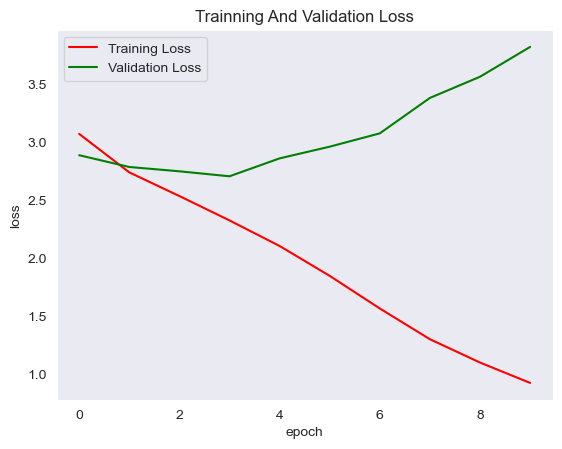

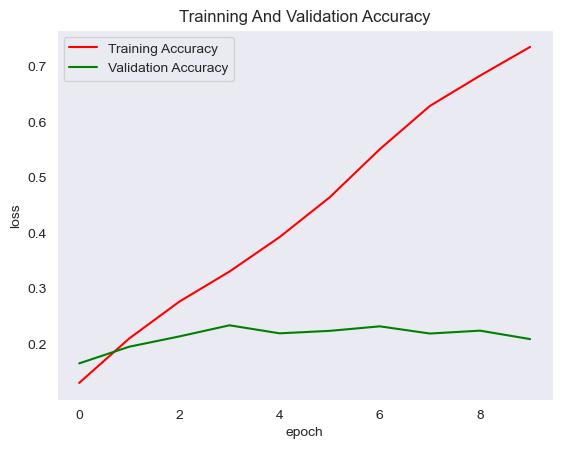

In [16]:
plot_loss_acc(statsrec[0], statsrec[2], 'Trainning And Validation Loss', 'Training Loss', 'Validation Loss')
plot_loss_acc(statsrec[1], statsrec[3], 'Trainning And Validation Accuracy', 'Training Accuracy', 'Validation Accuracy')

In [15]:
cnn = CNNModel()
cnn_loss_func = CrossEntropyLoss()
cnn_optimizer = optim.SGD(cnn.parameters(), lr=0.01, momentum=0.9)
epochs = 10


state_dict, statsrec = nn_train(
    cnn,
    train_loader,
    val_loader,
    cnn_loss_func,
    cnn_optimizer,
    10,
)

torch.save(state_dict, 'best-cnn-param.pt')

epoch:1---train loss:3.3917---train accuracy:0.0493---val loss:3.3143---val accuracy:0.0756
epoch:2---train loss:3.0632---train accuracy:0.1237---val loss:2.8648---val accuracy:0.1726
epoch:3---train loss:2.7501---train accuracy:0.2087---val loss:2.6378---val accuracy:0.2456
epoch:4---train loss:2.5587---train accuracy:0.2510---val loss:2.5284---val accuracy:0.2630
epoch:5---train loss:2.3791---train accuracy:0.3036---val loss:2.4604---val accuracy:0.3048
epoch:6---train loss:2.2531---train accuracy:0.3408---val loss:2.4098---val accuracy:0.3141
epoch:7---train loss:2.0834---train accuracy:0.3880---val loss:2.3998---val accuracy:0.3226
epoch:8---train loss:1.8942---train accuracy:0.4372---val loss:2.3429---val accuracy:0.3430
epoch:9---train loss:1.6946---train accuracy:0.4922---val loss:2.3043---val accuracy:0.3541
epoch:10---train loss:1.4345---train accuracy:0.5620---val loss:2.5283---val accuracy:0.3519


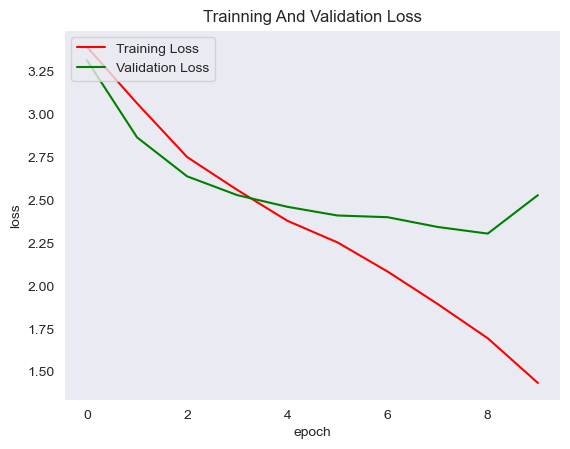

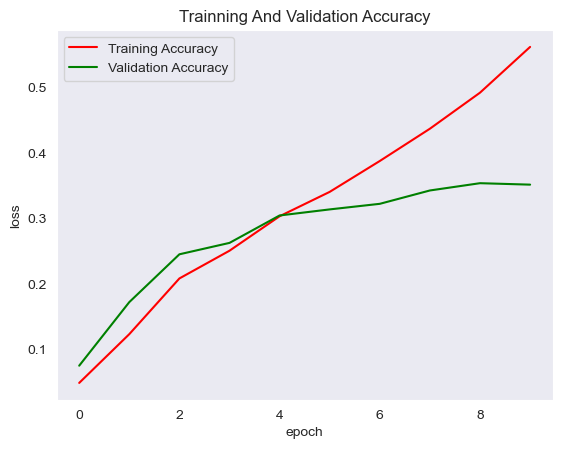

In [16]:
plot_loss_acc(statsrec[0], statsrec[2], 'Trainning And Validation Loss', 'Training Loss', 'Validation Loss')
plot_loss_acc(statsrec[1], statsrec[3], 'Trainning And Validation Accuracy', 'Training Accuracy', 'Validation Accuracy')

> Comment on your model and results that should include number of parameters in each model and why CNN over MLP for image classification task?

### 2.2 Generating confusion matrix and ROC curves
- Use your CNN architecture with best accuracy to generate two confusion matrices, one for the training set and another for the validation set. Remember to use the whole validation and training sets, and to include all your relevant code. Display the confusion matrices in a meaningful way that clearly indicates what percentage of the data is represented in each position.
- Display ROC curve for 5 top classes with area under the curve

In [51]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tqdm import tqdm
import seaborn as sns

def plot_cf(model, loader, categories_names):
    all_preds= []
    all_labels= []

    with torch.no_grad():
        for X, y in tqdm(loader):
            X = X.to(device)
            preds=model(X)


            all_preds += torch.argmax(preds, dim=1).cpu().detach().tolist()
            all_labels += y.tolist()
        fig, ax = plt.subplots(figsize=(25,25))
        cm=confusion_matrix(all_labels, all_preds)
        # print(cm)
        conf_matrix=pd.DataFrame(data=cm,
                                 columns=categories_names,
                                 index=categories_names)

        tar_list = []
        for i in list(class_map.keys()):
            tar_list.append([i, conf_matrix.loc[i, i]])

        topkclass = pd.DataFrame(tar_list, columns=['class', 'num']).sort_values('num', ascending=False).iloc[:5, 0].tolist()

        sns.heatmap(conf_matrix, annot=True, fmt="d",)


        plt.show()

        return topkclass

100%|██████████| 169/169 [00:04<00:00, 39.80it/s]


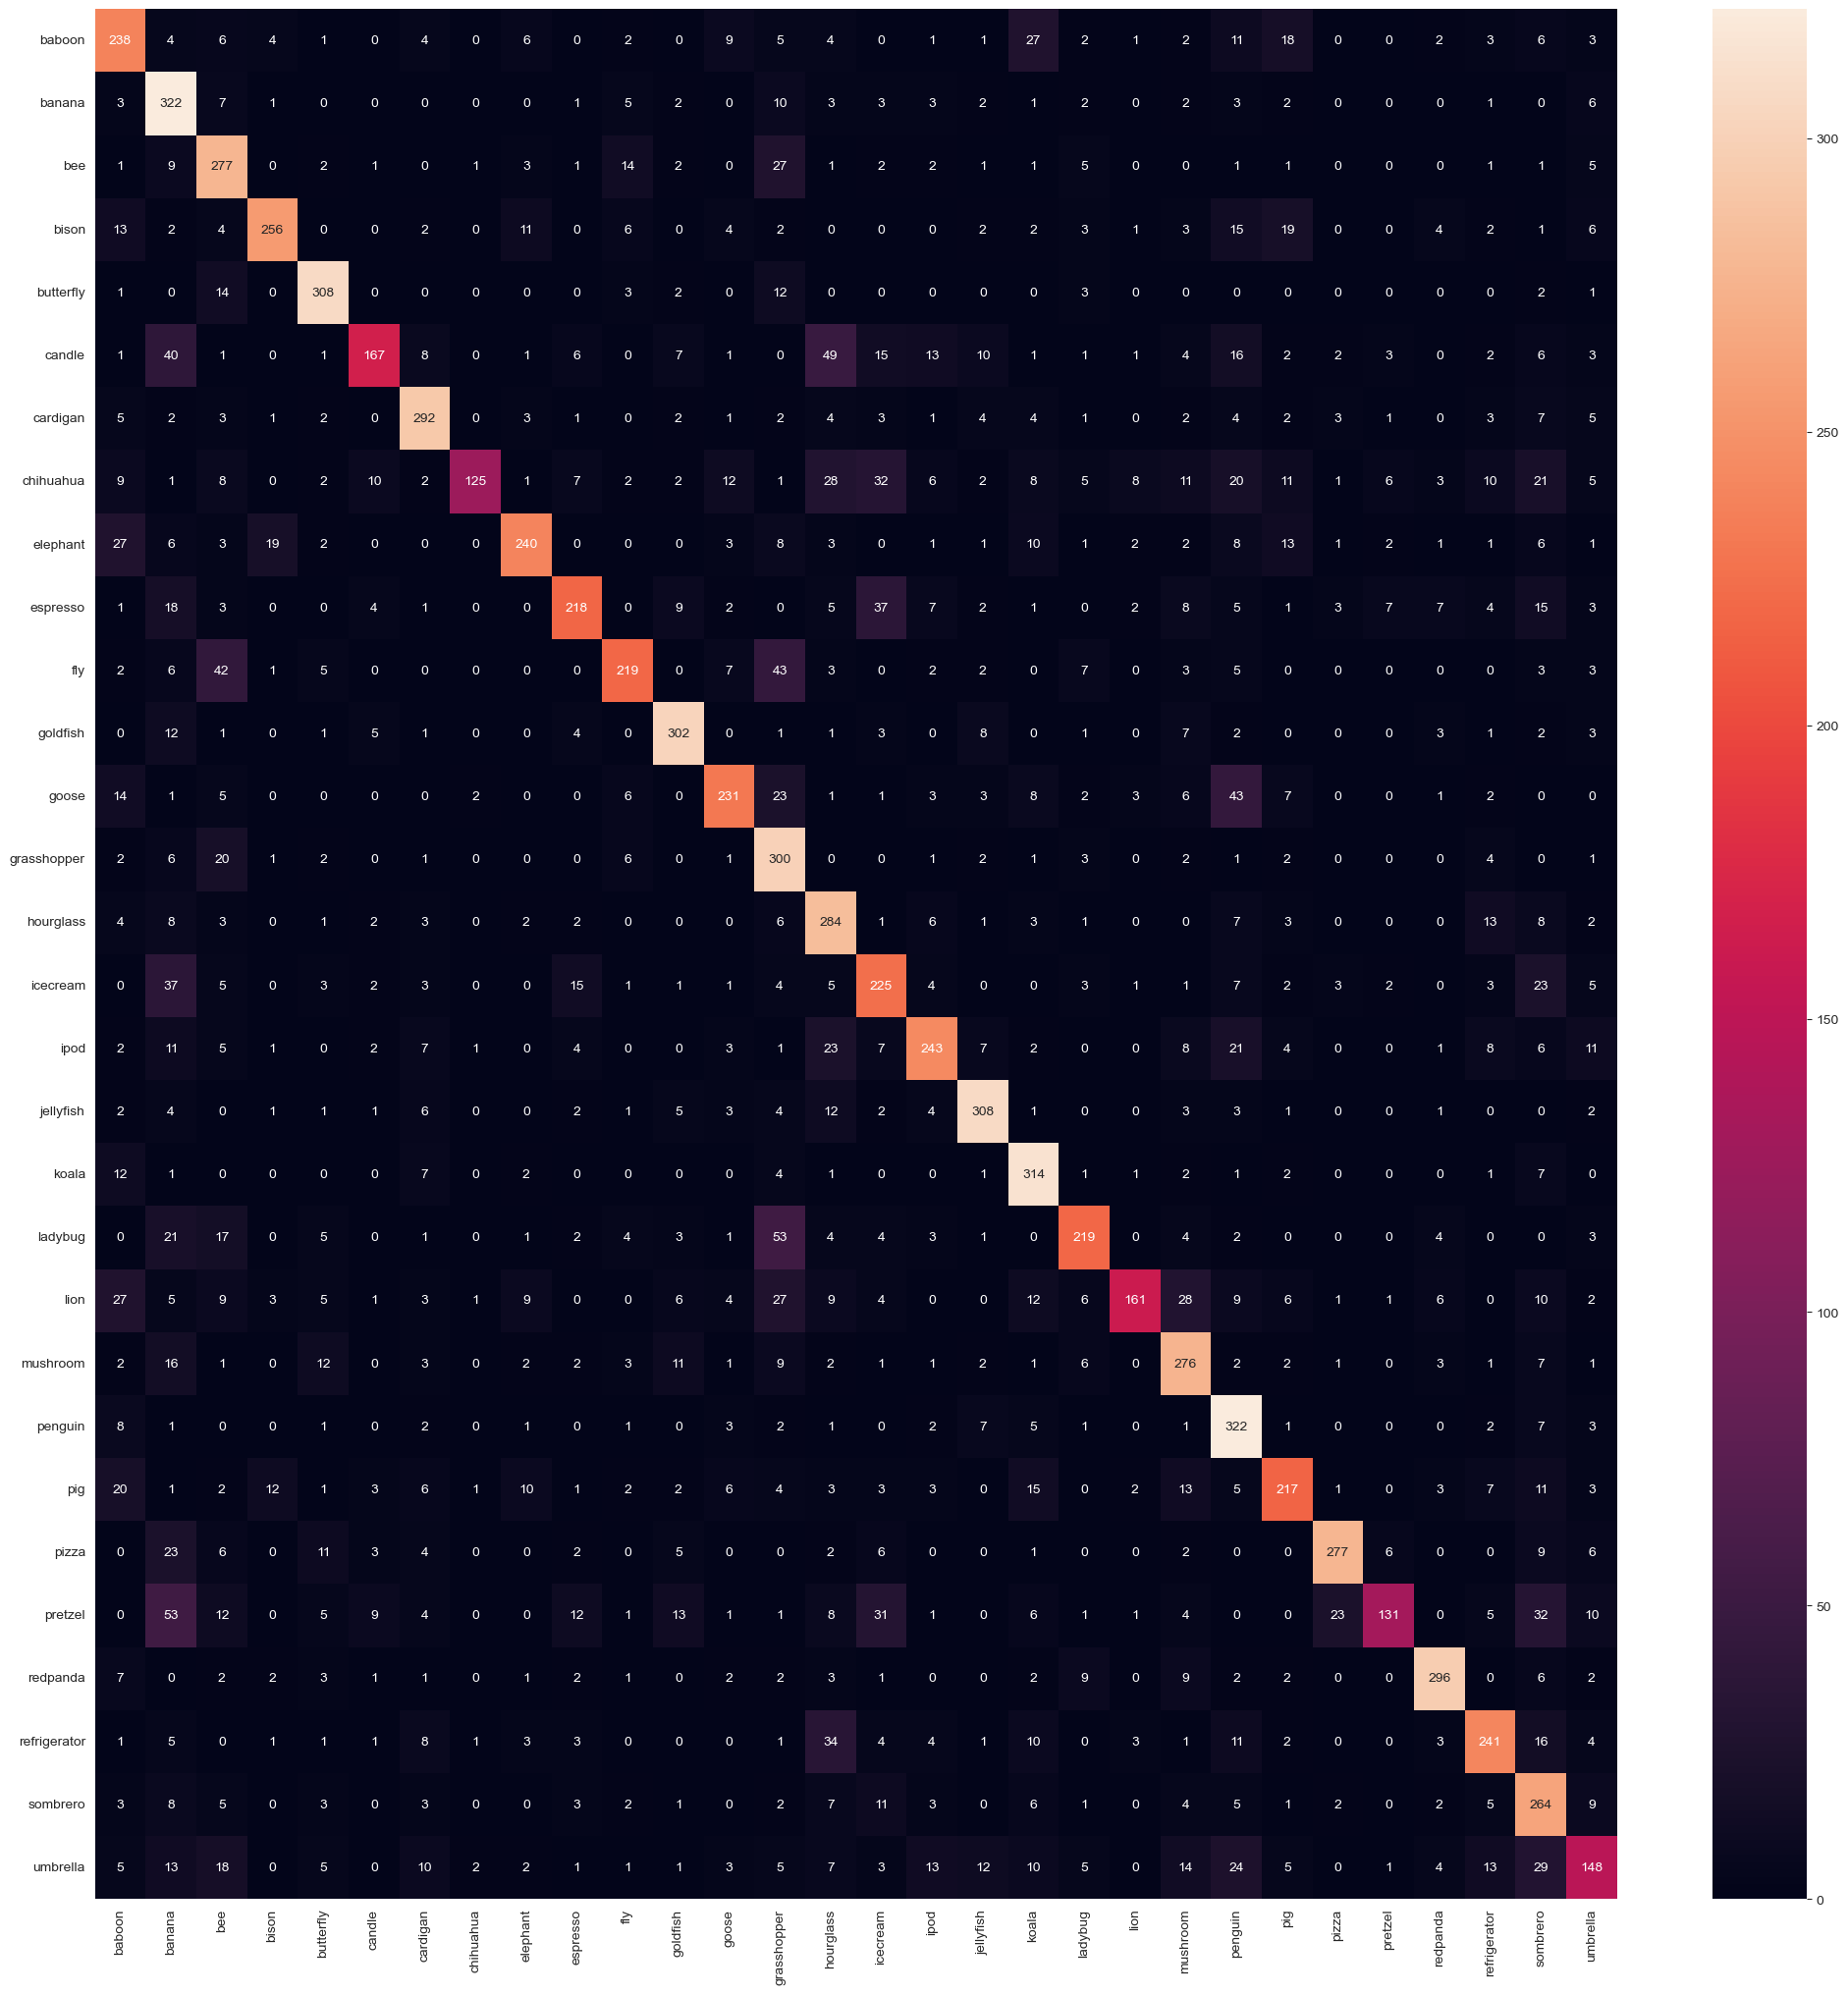

In [46]:
cnn.load_state_dict(state_dict)
train_top_5 = plot_cf(cnn.to(device), train_loader, list(class_map.keys()))

100%|██████████| 43/43 [00:01<00:00, 40.30it/s]


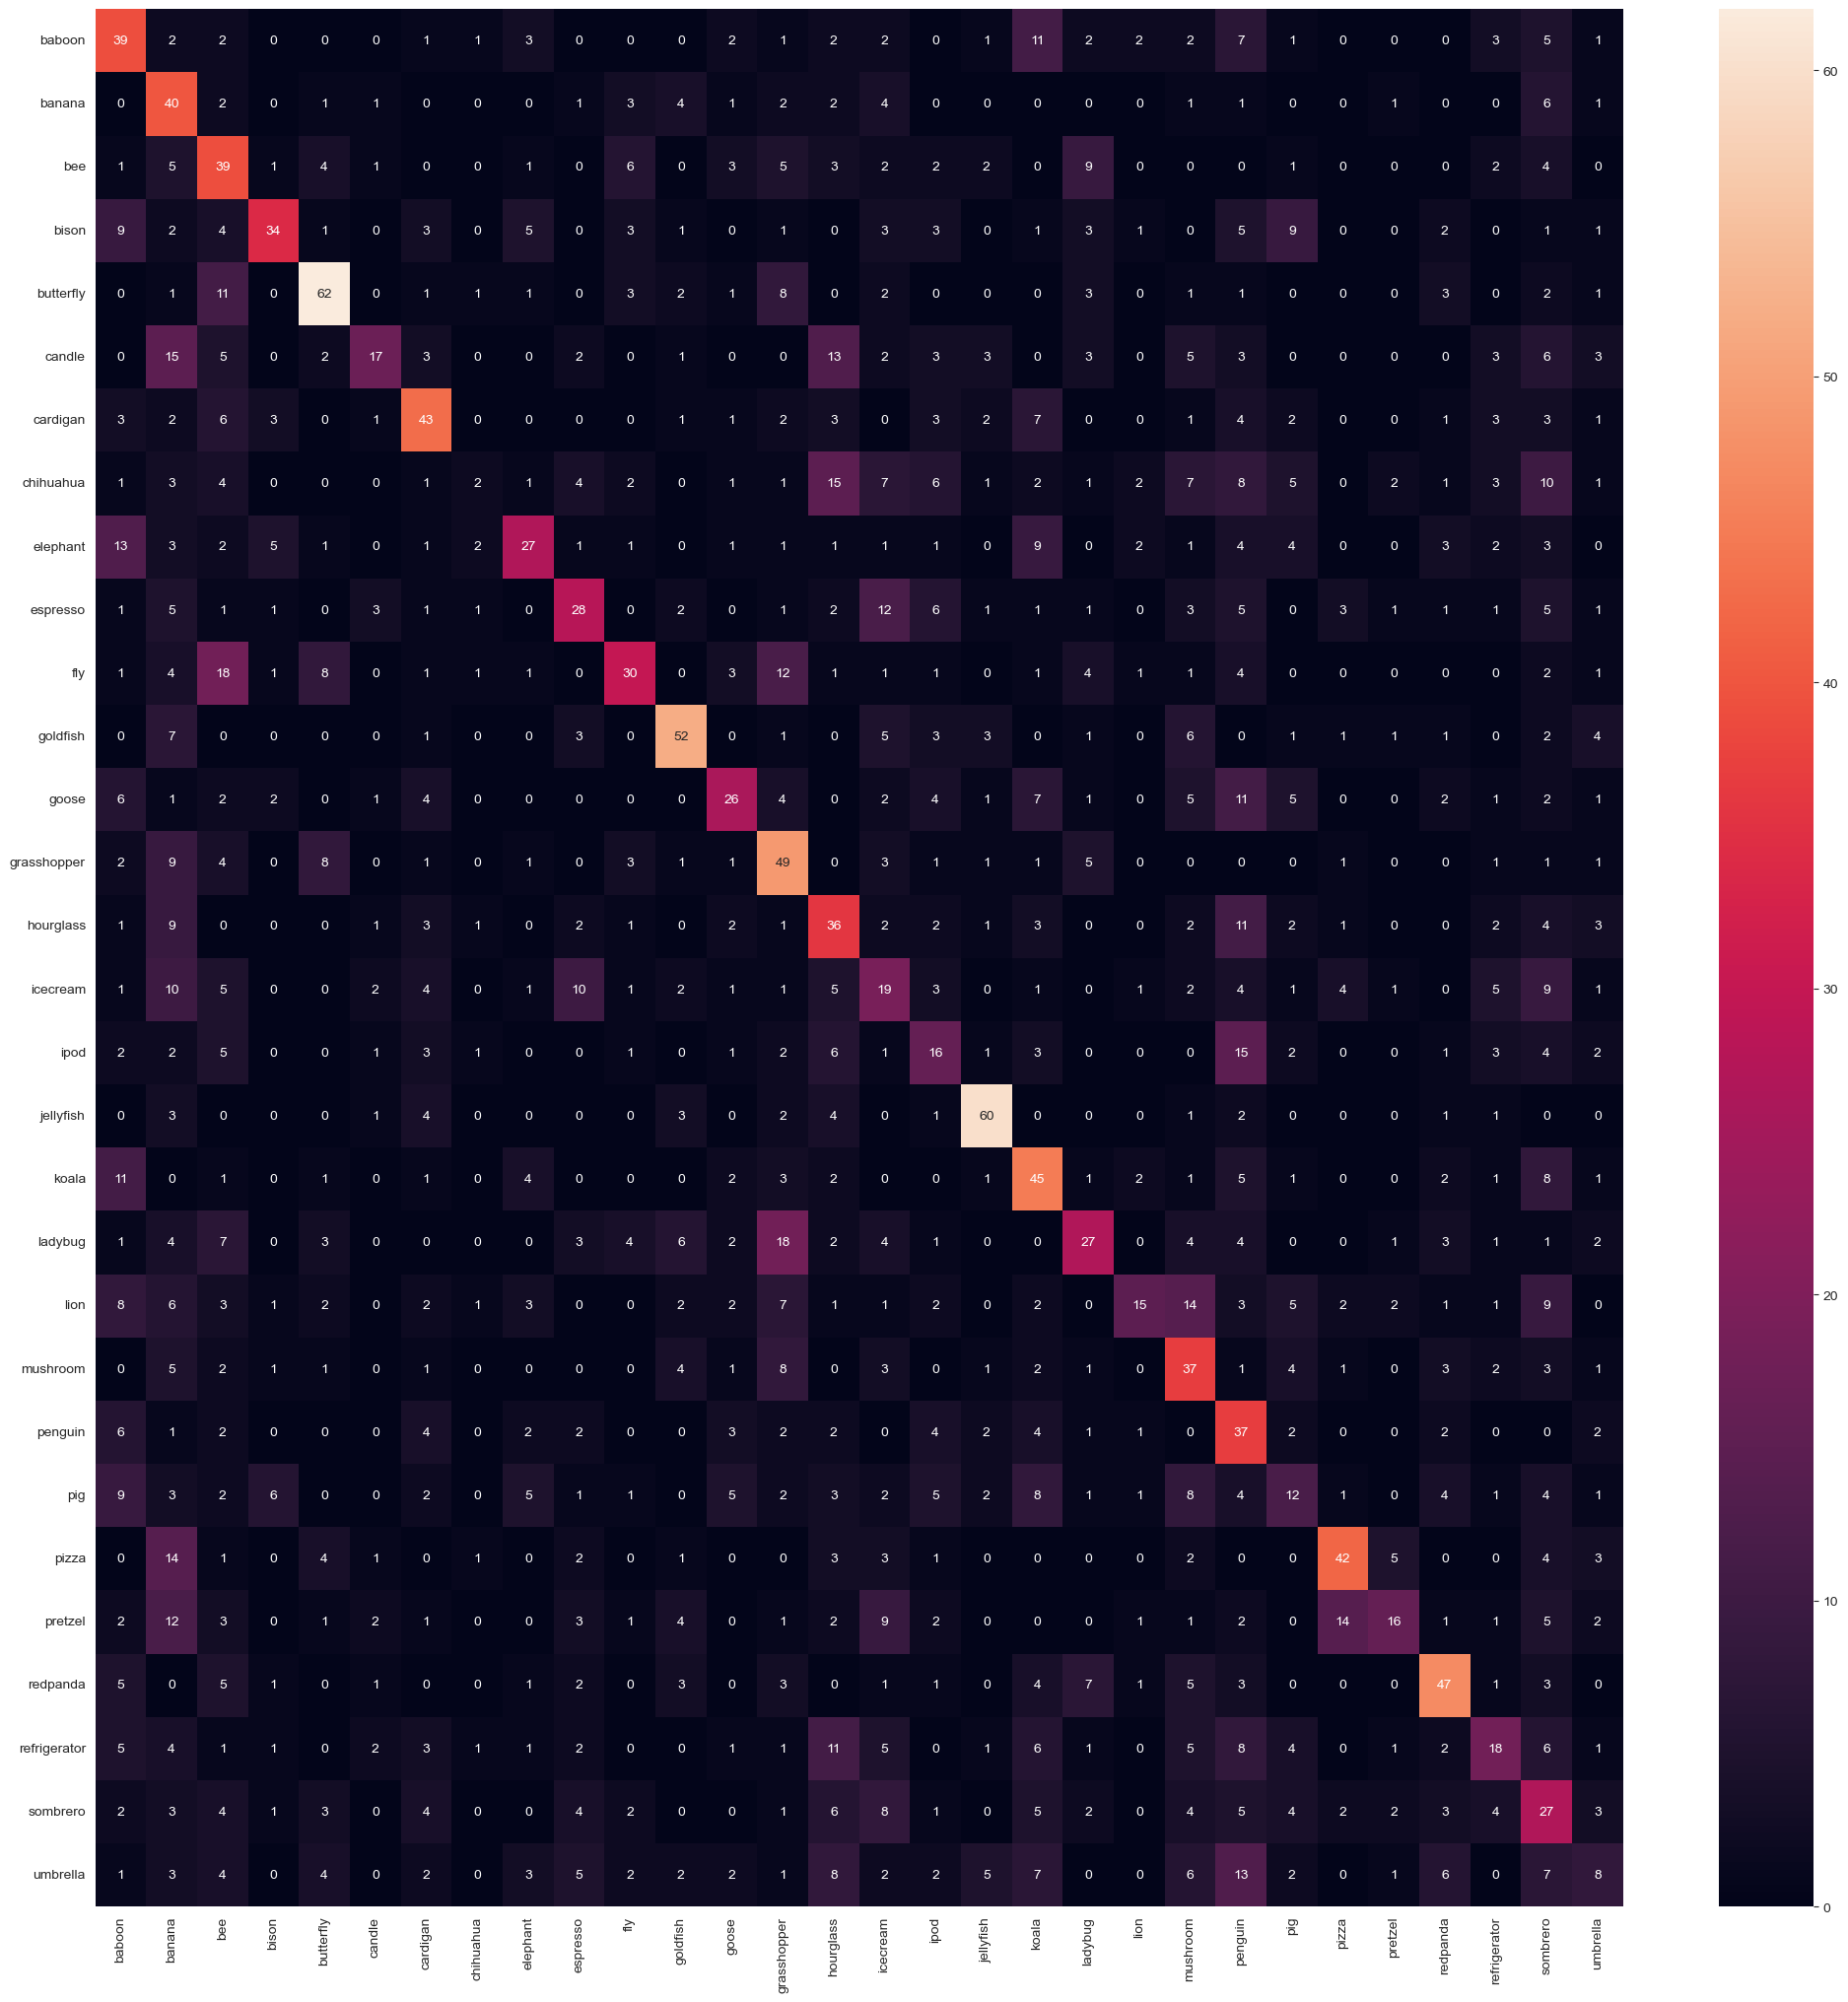

In [47]:
val_top_5 = plot_cf(cnn.to(device), val_loader, list(class_map.keys()))

In [50]:
val_top_5

['butterfly', 'jellyfish', 'goldfish', 'grasshopper', 'redpanda']

In [77]:
def plot_roc(model, loader):
    score_list = []
    label_list = []

    with torch.no_grad():
        for X, y in tqdm(loader):
            X, y = X.to(device), y.to(device)
            preds=model(X)

            score_list.extend(preds.detach().cpu().numpy())
            label_list.extend(y.detach().cpu().numpy())

        score_array = np.array(score_list)
        label_tensor = torch.tensor(label_list)
        label_tensor = label_tensor.reshape((label_tensor.shape[0], 1))
        label_onehot = torch.zeros(label_tensor.shape[0], 30)
        label_onehot.scatter_(dim=1, index=label_tensor, value=1)
        label_onehot = np.array(label_onehot)

        fpr_dict = dict()
        tpr_dict = dict()
        roc_auc_dict = dict()
        for i in range(30):
            fpr_dict[i], tpr_dict[i], _ = roc_curve(label_onehot[:, i], score_array[:, i])
            roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])
        # micro
        fpr_dict["top5"], tpr_dict["top5"], _ = roc_curve(label_onehot.ravel(), score_array.ravel())
        roc_auc_dict["top5"] = auc(fpr_dict["top5"], tpr_dict["top5"])


        plt.figure()
        lw = 2
        plt.plot(fpr_dict["top5"], tpr_dict["top5"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc_dict["top5"]),
                 color='deeppink', linestyle=':', linewidth=4)
        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()

100%|██████████| 169/169 [00:02<00:00, 62.10it/s]


score_array: (10800, 30)
label_onehot: (10800, 30)


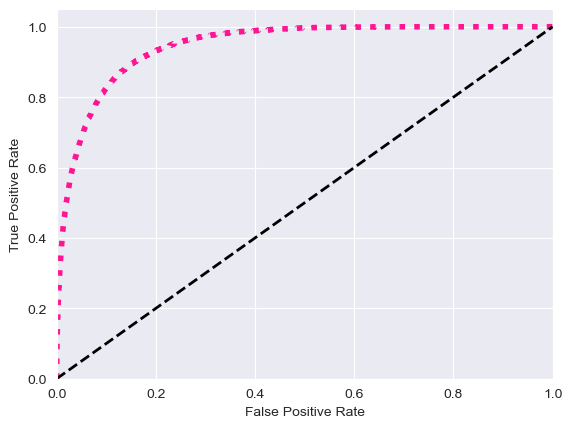

In [78]:
plot_roc(cnn, train_loader)

**Note: All parts below here relate to the CNN model only and not the MLP! You are advised to use your final CNN model only for each of the following parts.**

### 2.3 Strategies for tackling overfitting 
Using your (final) CNN model, use the strategies below to avoid overfitting. You can reuse the network weights from previous training, often referred to as ``fine tuning``. 
*   **2.3.1** Data augmentation
*   **2.3.2** Dropout
*   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)

Plot loss and accuracy graphs per epoch side by side for each implemented strategy.

#### 2.3.1 Data augmentation

> Implement at least five different data augmentation techniques that should include both photometric and geometric augmentations. 

> Provide graph and comment on what you observe


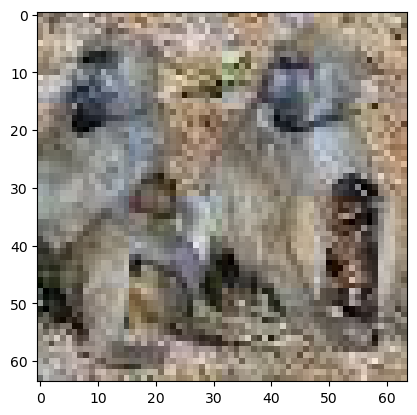

In [83]:
# original image
img = Image.open(list(image_file_map.keys())[0]).convert("RGB")
plt.imshow(img)

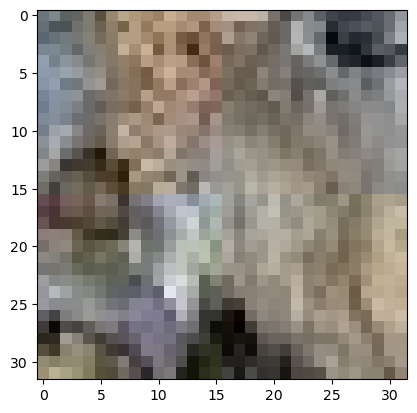

In [89]:
# CenterCrop
imgCC = transforms.CenterCrop((32, 32)).forward(img)
plt.imshow(imgCC)

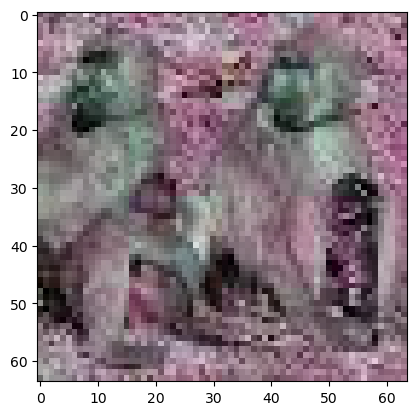

In [86]:
imgCJ = transforms.ColorJitter(brightness=0.5, hue= 0.3).forward(img)
plt.imshow(imgCJ)

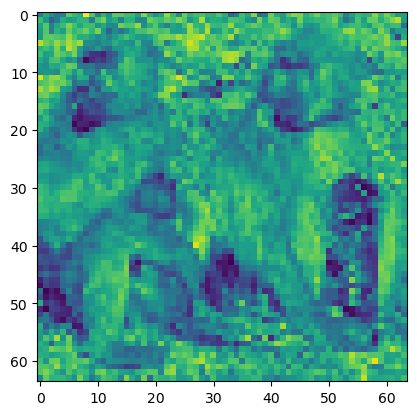

In [87]:
imgGS = transforms.Grayscale(1)(img)
plt.imshow(imgGS)

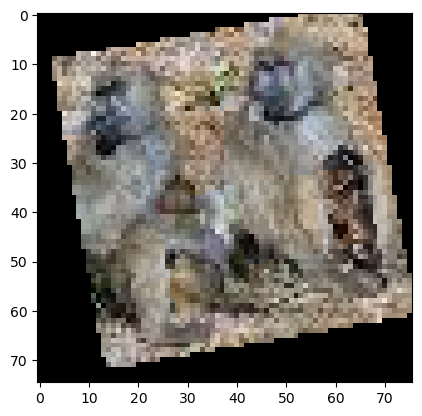

In [88]:
imgRR = transforms.RandomRotation(degrees=(0, 30), center=((int(img.size[0]/3), int(img.size[1]/3))), expand=True)(img)
plt.imshow(imgRR)

In [81]:
# Your code here!
train_test_split = 0.2
transform=  transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.5, hue= 0.3),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
batch_size = 64
seed = 0

train_loader,val_loader=imageDataLoader(
    image_file_map,
    batch_size=batch_size,
    train_test_split=0.2,
    seed=0,
    transform=transform
)

cnn_data_aug = CNNModel()
cnn_data_aug_loss_func = CrossEntropyLoss()
cnn_data_aug_optimizer = optim.Adam(cnn_data_aug.parameters(), lr=0.001)
#TO COMPLETE --> Running you CNN model class
epochs = 10

state_dict, statsrec = nn_train(
    cnn_data_aug,
    train_loader,
    val_loader,
    cnn_data_aug_loss_func,
    cnn_data_aug_optimizer,
    epochs = epochs
)

epoch:1---train loss:3.2609---train accuracy:0.0753---val loss:3.0689---val accuracy:0.1348
epoch:2---train loss:2.9075---train accuracy:0.1735---val loss:2.8399---val accuracy:0.2000
epoch:3---train loss:2.6517---train accuracy:0.2409---val loss:2.7043---val accuracy:0.2404
epoch:4---train loss:2.4390---train accuracy:0.2973---val loss:2.5633---val accuracy:0.2837
epoch:5---train loss:2.2440---train accuracy:0.3500---val loss:2.5507---val accuracy:0.2952
epoch:6---train loss:2.0543---train accuracy:0.3996---val loss:2.5115---val accuracy:0.3026
epoch:7---train loss:1.8577---train accuracy:0.4506---val loss:2.5469---val accuracy:0.2963
epoch:8---train loss:1.6624---train accuracy:0.5027---val loss:2.6542---val accuracy:0.2993
epoch:9---train loss:1.4169---train accuracy:0.5814---val loss:2.7174---val accuracy:0.3107
epoch:10---train loss:1.1659---train accuracy:0.6503---val loss:2.9952---val accuracy:0.3048


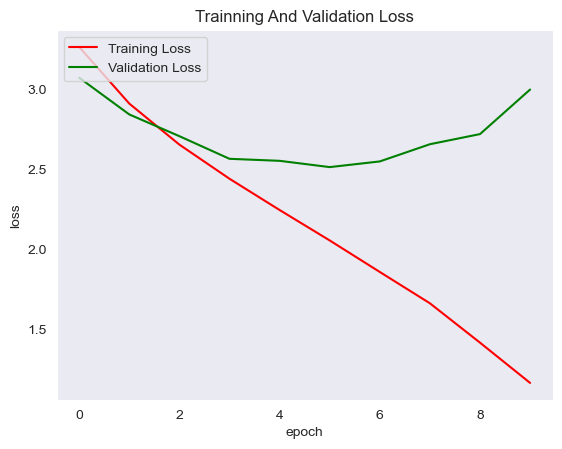

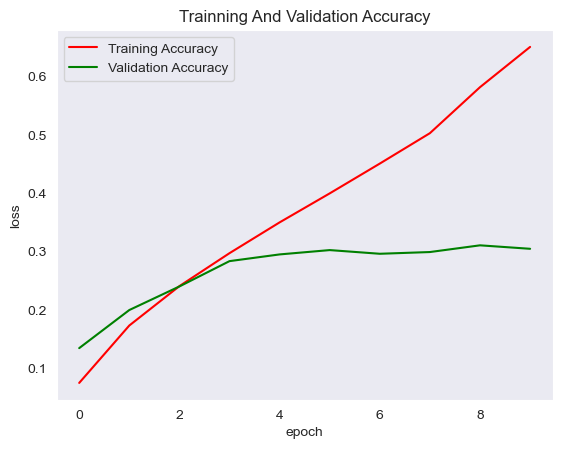

In [82]:
plot_loss_acc(statsrec[0], statsrec[2], 'Trainning And Validation Loss', 'Training Loss', 'Validation Loss')
plot_loss_acc(statsrec[1], statsrec[3], 'Trainning And Validation Accuracy', 'Training Accuracy', 'Validation Accuracy')

#### 2.3.2 Dropout

> Implement dropout in your model 

> Provide graph and comment on your choice of proportion used

In [83]:
# Your code here!
class CNNModel(Module):
    def __init__(self):
        super(CNNModel,self).__init__()
        self.conv1=nn.Sequential(
            nn.Conv2d(3, 6, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv2=nn.Sequential(
            nn.Conv2d(6, 12, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.out=nn.Sequential(
            nn.Linear(12*16*16,512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 30),
        )

    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=x.view(x.size(0),-1)
        x=self.out(x)
        return x

In [86]:
train_test_split = 0.2
transform=  transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
batch_size = 64
seed = 0

train_loader,val_loader=imageDataLoader(
    image_file_map,
    batch_size=batch_size,
    train_test_split=0.2,
    seed=0,
    transform=transform
)

cnn_drop = CNNModel()
cnn_drop_loss_func = CrossEntropyLoss()
cnn_drop_optimizer = optim.Adam(cnn_drop.parameters(), lr=0.001)
#TO COMPLETE --> Running you CNN model class
epochs = 10

state_dict, statsrec = nn_train(
    cnn_drop,
    train_loader,
    val_loader,
    cnn_drop_loss_func,
    cnn_drop_optimizer,
    epochs = epochs
)

epoch:1---train loss:3.1535---train accuracy:0.1014---val loss:2.8573---val accuracy:0.1744
epoch:2---train loss:2.7280---train accuracy:0.2099---val loss:2.6160---val accuracy:0.2463
epoch:3---train loss:2.4859---train accuracy:0.2705---val loss:2.4616---val accuracy:0.2985
epoch:4---train loss:2.2698---train accuracy:0.3401---val loss:2.3438---val accuracy:0.3307
epoch:5---train loss:2.0848---train accuracy:0.3916---val loss:2.3121---val accuracy:0.3463
epoch:6---train loss:1.9135---train accuracy:0.4309---val loss:2.3005---val accuracy:0.3485
epoch:7---train loss:1.7243---train accuracy:0.4876---val loss:2.2598---val accuracy:0.3581
epoch:8---train loss:1.5570---train accuracy:0.5331---val loss:2.3171---val accuracy:0.3630
epoch:9---train loss:1.3717---train accuracy:0.5828---val loss:2.4231---val accuracy:0.3533
epoch:10---train loss:1.1972---train accuracy:0.6336---val loss:2.4946---val accuracy:0.3511


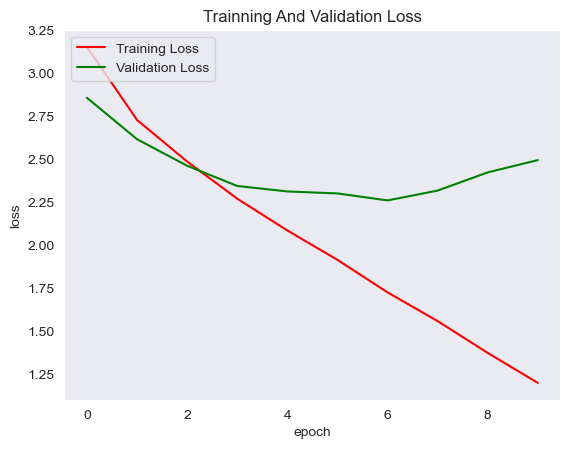

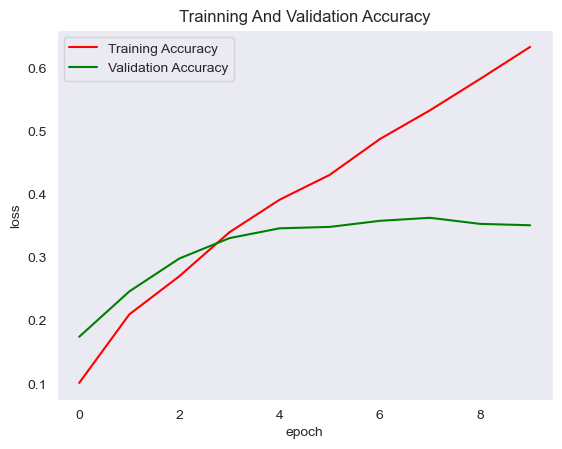

In [87]:
plot_loss_acc(statsrec[0], statsrec[2], 'Trainning And Validation Loss', 'Training Loss', 'Validation Loss')
plot_loss_acc(statsrec[1], statsrec[3], 'Trainning And Validation Accuracy', 'Training Accuracy', 'Validation Accuracy')

#### 2.3.3 Hyperparameter tuning

> Use learning rates [0.1, 0.001, 0.0001]

> Provide separate graphs for loss and accuracy, each showing performance at three different learning rates

In [15]:
# Your code here!
cnn_hp_1 = CNNModel()
cnn_hp_2 = CNNModel()
cnn_hp_3 = CNNModel()
cnn_hp_loss_func = CrossEntropyLoss()
#TO COMPLETE --> Running you CNN model class
epochs = 10

lr = [0.1, 0.01, 0.001]
model = [cnn_hp_1, cnn_hp_2, cnn_hp_3]
train_loss = []
val_loss = []
train_acc = []
val_acc = []

for i in range(len(lr)):
    print(f'training on {lr[i]}')
    print('--------------------------------------------------')
    cnn_hp_optimizer = optim.Adam(model[i].parameters(), lr=lr[i])
    state_dict, statsrec = nn_train(
        model[i],
        train_loader,
        val_loader,
        cnn_hp_loss_func,
        cnn_hp_optimizer,
        epochs = epochs
    )
    train_loss.append(statsrec[0])
    train_acc.append(statsrec[1])
    val_loss.append(statsrec[2])
    val_acc.append(statsrec[3])

training on 0.1
--------------------------------------------------
epoch:1---train loss:inf---train accuracy:0.0320---val loss:3.4172---val accuracy:0.0307
epoch:2---train loss:3.4189---train accuracy:0.0321---val loss:3.4165---val accuracy:0.0348
epoch:3---train loss:3.4168---train accuracy:0.0349---val loss:3.4165---val accuracy:0.0341
epoch:4---train loss:3.4190---train accuracy:0.0319---val loss:3.4178---val accuracy:0.0326
epoch:5---train loss:3.4192---train accuracy:0.0312---val loss:3.4203---val accuracy:0.0363
epoch:6---train loss:3.4192---train accuracy:0.0309---val loss:3.4153---val accuracy:0.0344
epoch:7---train loss:3.4194---train accuracy:0.0296---val loss:3.4240---val accuracy:0.0307
epoch:8---train loss:3.4186---train accuracy:0.0314---val loss:3.4203---val accuracy:0.0341
epoch:9---train loss:3.4186---train accuracy:0.0315---val loss:3.4047---val accuracy:0.0341
epoch:10---train loss:3.4195---train accuracy:0.0332---val loss:3.4224---val accuracy:0.0263
training on 0.0

In [23]:
def plot_loss_acc(data1, data2, data3, title, label1, label2,label3):
    fig, ax1 = plt.subplots()
    plt.grid()
    plt.plot(data1, 'r', label = label1)
    plt.plot(data2, 'g', label = label2)
    plt.plot(data3, 'g', label = label3)
    plt.legend(loc='upper left')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title(title)
    plt.show()

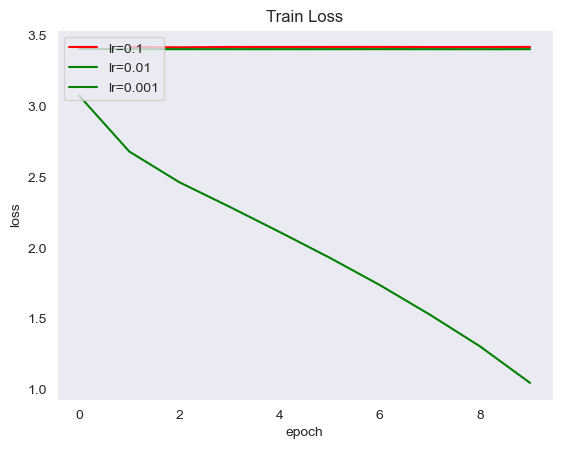

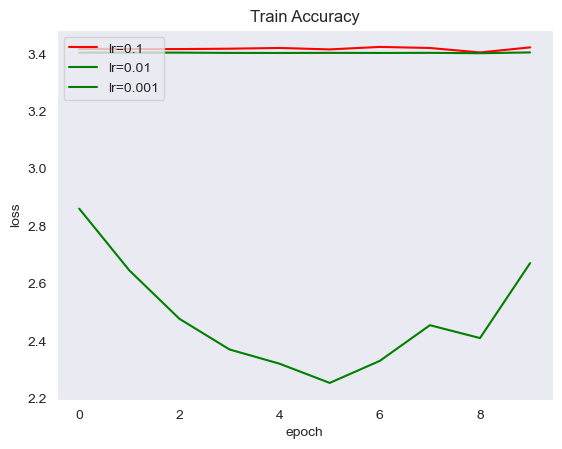

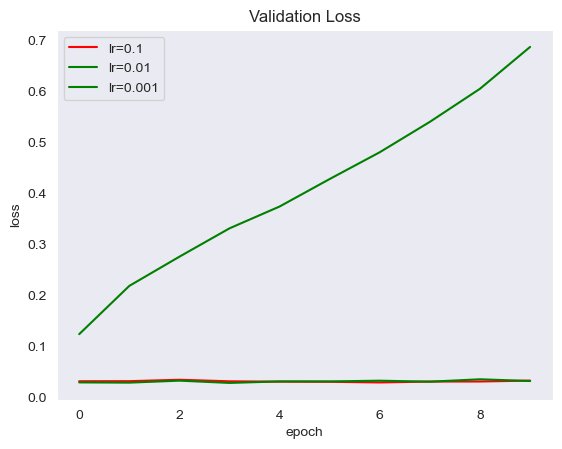

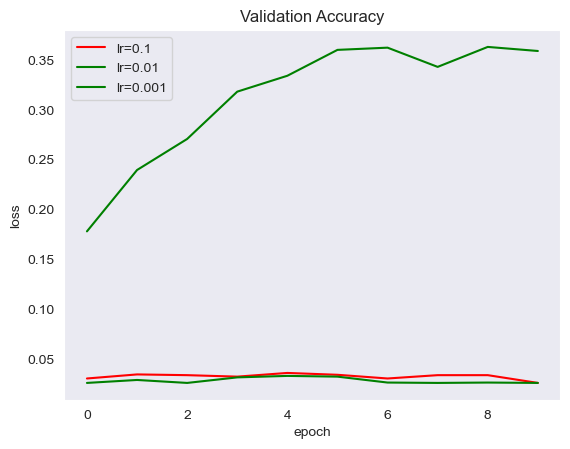

In [26]:
plot_loss_acc(train_loss[0], train_loss[1], train_loss[2], 'Train Loss', 'lr=0.1', 'lr=0.01', 'lr=0.001')
plot_loss_acc(val_loss[0], val_loss[1], val_loss[2], 'Train Accuracy', 'lr=0.1', 'lr=0.01', 'lr=0.001')
plot_loss_acc(train_acc[0], train_acc[1], train_acc[2], 'Validation Loss', 'lr=0.1', 'lr=0.01', 'lr=0.001')
plot_loss_acc(val_acc[0], val_acc[1], val_acc[2], 'Validation Accuracy', 'lr=0.1', 'lr=0.01', 'lr=0.001')

### 3 Model testing
Online evaluation of your model performance on the test set.

> Prepare the dataloader for test set

> Write evaluation code for writing predictions

> Upload it to Kaggle submission page [link](https://www.kaggle.com/t/917fe52f6a3c4855880a24b34f26db07) 


#### 3.1 Test class and predictions 

> Build a test class, prepare a test dataloader and generate predictions 

Create a PyTorch ```Dataset``` for the unlabeled test data in the test_set folder of the Kaggle competition and generate predictions using your final model. Test data can be downloaded [here](https://www.kaggle.com/competitions/comp5623m-artificial-intelligence/data?select=test_set)

In [15]:
# Your code here!
class TestImageDataset(Dataset):
    def __init__(self,filepath, transform=None):
        self.filepath=filepath
        self.transform=transform
        self.path =  os.listdir(filepath)

    def __len__(self):
        return len(self.path)

    def __getitem__(self,index):
        img_loc = os.path.join(self.filepath, self.path[index])
        image = Image.open(img_loc).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

In [20]:
class CNNModel(Module):
    def __init__(self):
        super(CNNModel,self).__init__()
        self.conv1=nn.Sequential(
            nn.Conv2d(3, 6, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv2=nn.Sequential(
            nn.Conv2d(6, 12, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.out=nn.Sequential(
            nn.Linear(12*16*16,512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 30),
        )

    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=x.view(x.size(0),-1)
        x=self.out(x)
        return x

In [21]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomGrayscale(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 64
seed = 0

train_loader,val_loader=imageDataLoader(
    image_file_map,
    batch_size=batch_size,
    train_test_split=0.2,
    seed=0,
    transform=transform
)

cnn_kaggle = CNNModel()
cnn_kaggle_loss_func = CrossEntropyLoss()
cnn_kaggle_optimizer = optim.Adam(cnn_kaggle.parameters(), lr=0.001)
#TO COMPLETE --> Running you CNN model class
epochs = 10

state_dict, statsrec = nn_train(
    cnn_kaggle,
    train_loader,
    val_loader,
    cnn_kaggle_loss_func,
    cnn_kaggle_optimizer,
    epochs = epochs
)

torch.save(state_dict, 'best-cnn-kagggle-param.pt')

epoch:1---train loss:3.1757---train accuracy:0.0967---val loss:2.9542---val accuracy:0.1559
epoch:2---train loss:2.7816---train accuracy:0.2019---val loss:2.6306---val accuracy:0.2467
epoch:3---train loss:2.5874---train accuracy:0.2475---val loss:2.5595---val accuracy:0.2781
epoch:4---train loss:2.4564---train accuracy:0.2799---val loss:2.4121---val accuracy:0.3085
epoch:5---train loss:2.3631---train accuracy:0.3127---val loss:2.3824---val accuracy:0.3237
epoch:6---train loss:2.2736---train accuracy:0.3393---val loss:2.3082---val accuracy:0.3370
epoch:7---train loss:2.2115---train accuracy:0.3577---val loss:2.2928---val accuracy:0.3352
epoch:8---train loss:2.1003---train accuracy:0.3847---val loss:2.2658---val accuracy:0.3522
epoch:9---train loss:2.0389---train accuracy:0.3981---val loss:2.2685---val accuracy:0.3515
epoch:10---train loss:1.9622---train accuracy:0.4202---val loss:2.1965---val accuracy:0.3726


In [30]:
transform=  transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
batch_size = 64

test_dataset=TestImageDataset("TinyImageNet30/test_set/test_set", transform=transform)
test_loader= DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
cnn_kaggle.load_state_dict(state_dict)
pred = []
for X_test in test_loader:
    X_test = X_test.to(device)
    cnn_kaggle.to(device)
    test_pred = cnn_kaggle(X_test)
    ret, predictions = torch.max(test_pred.data, 1)
    pred += list(predictions.cpu().detach().numpy())

NameError: name 'test_loader' is not defined

#### 3.2 Prepare your submission and upload to Kaggle

Save all test predictions to a CSV file and submit it to the private class Kaggle competition. **Please save your test CSV file submissions using your student username (the one with letters, ie., ``sc15jb``, not the ID with only numbers)**, for example, `sc15jb.csv`. That will help us to identify your submissions.

The CSV file must contain only two columns: ‘Id’ and ‘Category’ (predicted class ID) as shown below:

```txt
Id,Category
28d0f5e9_373c.JPEG,2
bbe4895f_40bf.JPEG,18
```

Please note you will get marks for higher performance.

The ‘Id’ column should include the name of the image. It is important to keep the same name as the one on the test set. Do not include any path, just the name of file (with extension). Your csv file must contain 1501 rows, one for each image in the test set and 1 row for the headers. [To submit please visit](https://www.kaggle.com/t/917fe52f6a3c4855880a24b34f26db07)

> You may submit multiple times. We will use your personal top entry for allocating marks for this. The class leaderboard will not affect marking (brownie points!).


In [34]:
test_result = pd.DataFrame(pred, columns=['Category'])
test_result['Id'] = os.listdir("TinyImageNet30/test_set/test_set")

In [35]:
test_result[['Id', 'Category']].to_csv('eg.csv', index=False)

### 4 Model Fine-tuning/transfer learning on CIFAR10 dataset

Fine-tuning is a way of applying or utilizing transfer learning. It is a process that takes a model that has already been trained for one task and then tunes or tweaks the model to make it perform a second similar task. You can perform finetuning in the following way:
- Train an entire model from scratch (large dataset, more computation)
- Freeze convolution base and train only last FC layers (small dataset and lower computation) 

> **Configuring your dataset**
   - Download your dataset using ``torchvision.datasets.CIFAR10``, [explained here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)
   - Split training dataset into training and validation set similar to above. *Note that the number of categories here are only 10*


In [37]:
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [177]:
# Your code here!
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomGrayscale(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Files already downloaded and verified
Files already downloaded and verified


In [178]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 2.245
[1,  4000] loss: 1.989
[1,  6000] loss: 1.769
[1,  8000] loss: 1.646
[1, 10000] loss: 1.578
[1, 12000] loss: 1.518
[2,  2000] loss: 1.472
[2,  4000] loss: 1.455
[2,  6000] loss: 1.395
[2,  8000] loss: 1.386
[2, 10000] loss: 1.379
[2, 12000] loss: 1.329
Finished Training


In [183]:
net = Net()
need_frozen_list = ["conv1.weight", "conv1.bias", "conv2.weight", "conv2.bias"]
for param in net.named_parameters():
    if param[0] in need_frozen_list:
        param[1].requires_grad = False
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001, momentum=0.9)

In [184]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 2.297
[1,  4000] loss: 2.241
[1,  6000] loss: 2.076
[1,  8000] loss: 1.966
[1, 10000] loss: 1.915
[1, 12000] loss: 1.862
[2,  2000] loss: 1.816
[2,  4000] loss: 1.789
[2,  6000] loss: 1.778
[2,  8000] loss: 1.747
[2, 10000] loss: 1.759
[2, 12000] loss: 1.738
Finished Training


> Load pretrained AlexNet from PyTorch - use model copies to apply transfer learning in different configurations

In [38]:
# Your code here!
ANmodel = torchvision.models.alexnet(pretrained=True)

/Users/xiaoziqi/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/xiaoziqi/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### 4.1 Apply transfer learning initialise with pretrained model weights
Use pretrained weights from AlexNet only (on the right of figure) to initialise your model. 

<img src="https://upload.wikimedia.org/wikipedia/commons/c/cc/Comparison_image_neural_networks.svg" style="width:1000px;height:400px;">
<caption><center> <u>Figure</u>: Two models are given here: LeNet and AlexNet for image classification. However, you have to use **only AlexNet**.</center></caption>

> Configuration 1: No frozen layers

In [ ]:
# https://cloud.tencent.com/developer/article/2075682

In [39]:
# Your model changes here - also print trainable parameters
ANmodel.buffers

<bound method Module.buffers of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216,

In [40]:
ANmodel.classifier[6] = nn.Linear(in_features=4096, out_features=10, bias=True)
for m, n in ANmodel.named_parameters():
    print(m, n.requires_grad)

features.0.weight True
features.0.bias True
features.3.weight True
features.3.bias True
features.6.weight True
features.6.bias True
features.8.weight True
features.8.bias True
features.10.weight True
features.10.bias True
classifier.1.weight True
classifier.1.bias True
classifier.4.weight True
classifier.4.bias True
classifier.6.weight True
classifier.6.bias True


In [42]:
train_transform = transforms.Compose(
    [transforms.Resize(230),
     transforms.CenterCrop(224),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

test_transform = transforms.Compose(
    [transforms.Resize(230),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

optimizer = optim.Adam(ANmodel.classifier.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

epochs = 10
train_steps = len(trainloader)
val_length = len(testloader)
best_acc = 0.0

Files already downloaded and verified
Files already downloaded and verified


In [43]:
state_dict, statsrec = nn_train(
    ANmodel,
    trainloader,
    testloader,
    loss_function,
    optimizer,
    epochs
)

KeyboardInterrupt: 

#### 4.2 Fine-tuning model with frozen layers

> Configuration 2: Frozen base convolution blocks

In [201]:
# Your changes here - also print trainable parameters
freez_list = ['features.0.weight',
              'features.0.bias',
              'features.3.weight',
              'features.3.bias',
              'features.6.weight',
              'features.6.bias',
              'features.8.weight',
              'features.8.bias',
              'features.10.weight',
              'features.10.bias']

for param in net.named_parameters():
    if param[0] in freez_list:
        param[1].requires_grad = False
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, ANmodel.parameters()), lr=0.001, momentum=0.9)

In [202]:
epochs = 5

state_dict, statsrec = nn_train(
    ANmodel,
    trainloader,
    testloader,
    criterion,
    optimizer,
    epochs
)

KeyboardInterrupt: 

#### 4.3 Compare above configurations and comment on comparative performance

In [ ]:
# Your graphs here and please provide comment in markdown in another cell

### 5 Model comparisons
We often need to compare our model with other state-of-the-art methods to understand how well it performs compared to existing architectures. Here you will thus compare your model design with AlexNet on the TinyImageNet30 dataset

#### 5.1 Finetune AlexNet on TinyImageNet30
> Load AlexNet as you did above

> Train AlexNet on TinyImageNet30 dataset until convergence. Make sure you use the same dataset

In [44]:
# Your code here!
train_test_split = 0.2
transform=  transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomGrayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
batch_size = 64
seed = 0

train_loader,vald_loader=imageDataLoader(
    image_file_map,
    batch_size=batch_size,
    train_test_split=0.2,
    seed=0,
    transform=transform
)

In [47]:
ANmodel = torchvision.models.alexnet(pretrained=True)
loss_func = CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

In [48]:
%%time
epochs = 5

state_dict, statsrec = nn_train(
    ANmodel,
    trainloader,
    testloader,
    loss_func,
    optimizer,
    epochs
)

KeyboardInterrupt: 

#### 5.2 Compare results on validation set of TinyImageNet30
> Loss graph, top1 accuracy, confusion matrix and execution time for your model (say, mymodel and AlexNet)


### 6 Interpretation of results 

> Please use TinyImageNet30 dataset for all results

#### 6.1-6.2 Implement grad-CAM and visualise results

- Use an existing library to initiate grad-CAM 

        - To install: !pip install torchcam
        - Call SmoothGradCAMpp: from torchcam.methods import SmoothGradCAMpp
        - Apply to your model 

You can see the details here: https://github.com/frgfm/torch-cam

- Apply grad-CAM to your model on at least four correctly classified images
- Apply grad-CAM on retrained AlexNet on at least four incorrectly classified images

>It is recommended to first read the relevant paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391), and refer to relevant course material.


**HINT for displaying images with grad-CAM:**

Display ```heatmap``` as a coloured heatmap superimposed onto the original image. We recommend the following steps to get a clear meaningful display. 

From torchcam.utils import overlay_mask. But remember to resize your image, normalise it and put a 1 for the batch dimension (e.g, [1, 3, 224, 224]) 


In [212]:
# Your code here!
!pip install torchcam

In [14]:
# Your code here!
import torch.nn.functional as F
class CNNModel(Module):
    def __init__(self):
        super(CNNModel,self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, 1, 2)
        self.conv2 = nn.Conv2d(6, 12, 5, 1, 2)
        self.pooling = nn.MaxPool2d(2)
        self.linear1 = nn.Linear(12*16*16,512)
        self.dropout = nn.Dropout(p=0.3)
        self.linear2 = nn.Linear(512, 128)
        self.linear3 = nn.Linear(128, 30)


    def forward(self,x):
        x = F.relu(self.pooling(self.conv1(x)))
        x = F.relu(self.pooling(self.conv2(x)))
        x = x.view(x.size(0),-1)
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [26]:
class ImageDataset(Dataset):
    def __init__(self,ids,label_mapping,transform=None):
        self.ids=ids
        self.label_mapping=label_mapping
        self.transform=transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self,index):
        image=Image.open(self.ids[index]).convert("RGB")
        #convert_tensor = transforms.ToTensor()
        #img=convert_tensor(img).permute(1,2,0)
        if self.transform:
            image = self.transform(image)

        label=self.label_mapping[self.ids[index]]

        return image, label, self.ids[index]

In [27]:
def imageDataLoader(image_file_map, batch_size=64, train_test_split=0.3, seed=0, transform=transforms.ToTensor()):

    dataset=ImageDataset(list(image_file_map.keys()), image_file_map, transform=transform)
    len_train= int(len(image_file_map) * (1 - train_test_split))
    len_vald = int(len(image_file_map) * train_test_split)

    #splitting data
    train_set, vald_set = random_split(dataset, [len_train, len_vald], generator=Generator().manual_seed(seed))

    #DataLoaders
    train_loader= DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
    vald_loader= DataLoader(dataset=vald_set, batch_size=batch_size, shuffle=True)

    return train_loader,vald_loader

In [15]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomGrayscale(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 64
seed = 0
device = torch.device('cpu')

train_loader, val_loader=imageDataLoader(
    image_file_map,
    batch_size=batch_size,
    train_test_split=0.2,
    seed=0,
    transform=transform
)

cnn = CNNModel()
cnn_loss_func = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn.parameters(), lr=0.001)
#TO COMPLETE --> Running you CNN model class
epochs = 10

state_dict, statsrec = nn_train(
    cnn,
    train_loader,
    val_loader,
    cnn_loss_func,
    cnn_optimizer,
    epochs = epochs
)

torch.save(state_dict, 'best-cnn-kagggle-param.pt')

epoch:1---train loss:3.1769---train accuracy:0.1028---val loss:2.9435---val accuracy:0.1537
epoch:2---train loss:2.8453---train accuracy:0.1866---val loss:2.7170---val accuracy:0.2293
epoch:3---train loss:2.6308---train accuracy:0.2441---val loss:2.5997---val accuracy:0.2659
epoch:4---train loss:2.4601---train accuracy:0.2962---val loss:2.5786---val accuracy:0.2704
epoch:5---train loss:2.3118---train accuracy:0.3347---val loss:2.3652---val accuracy:0.3281
epoch:6---train loss:2.1909---train accuracy:0.3659---val loss:2.3118---val accuracy:0.3419
epoch:7---train loss:2.0596---train accuracy:0.4020---val loss:2.3515---val accuracy:0.3415
epoch:8---train loss:1.9759---train accuracy:0.4247---val loss:2.2522---val accuracy:0.3537
epoch:9---train loss:1.8734---train accuracy:0.4483---val loss:2.2436---val accuracy:0.3711
epoch:10---train loss:1.7741---train accuracy:0.4769---val loss:2.2181---val accuracy:0.3800


In [16]:
cnn = CNNModel()
cnn.load_state_dict(torch.load('best-cnn-kagggle-param.pt'))

<All keys matched successfully>

In [53]:
# Your code here!
from torchcam.methods import SmoothGradCAMpp
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image

img_path = list(image_file_map.keys())[0]
cam_extractor = SmoothGradCAMpp(cnn, input_shape=(3, 64, 64), target_layer='conv2')

In [30]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomGrayscale(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 1
seed = 0

train_loader,val_loader=imageDataLoader(
    image_file_map,
    batch_size=batch_size,
    train_test_split=0.2,
    seed=0,
    transform=transform
)

In [35]:
path_list = []
for X, y, path in val_loader:
    if len(path_list) == 4:
        break
    else:
        y_pred = cnn(X)
        if torch.argmax(y_pred, dim=1) == y:
            path_list.append(path[0])


In [36]:
path[0]

'TinyImageNet30/train_set/train_set/pig/n02395406_1.JPEG'

In [54]:
def show_cam(img_path):
    img = read_image(img_path)
    # Preprocess it for your chosen model
    input_tensor = normalize(resize(img, (64, 64)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    out = cnn(input_tensor.unsqueeze(0))
    cams = cam_extractor(out.squeeze(0).argmax().item(), out.cpu())

    # The raw CAM
    for name, cam in zip(cam_extractor.target_names, cams):
        plt.imshow(cam.squeeze(0).numpy()); plt.axis('off'); plt.title(name); plt.show()

    # Overlayed on the image
    for name, cam in zip(cam_extractor.target_names, cams):
        result = overlay_mask(to_pil_image(img), to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5)
        plt.imshow(result); plt.axis('off'); plt.title(name); plt.show()

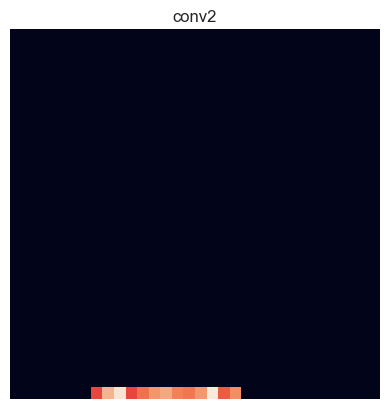

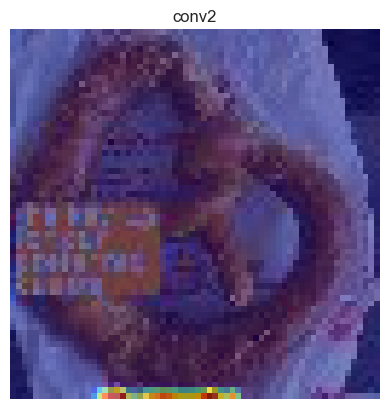

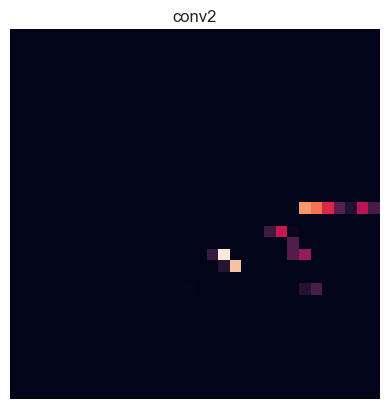

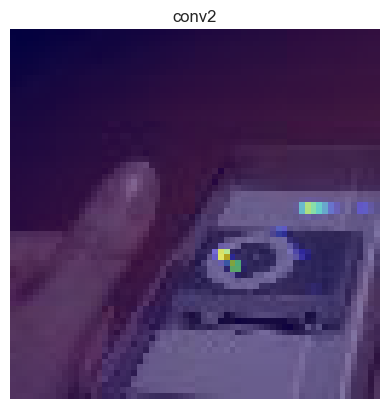

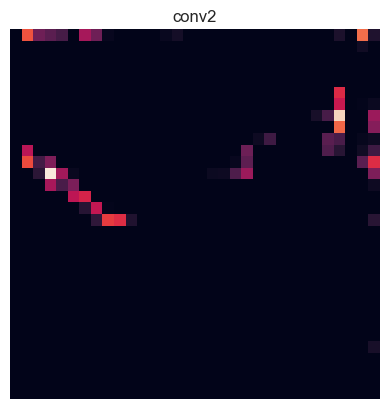

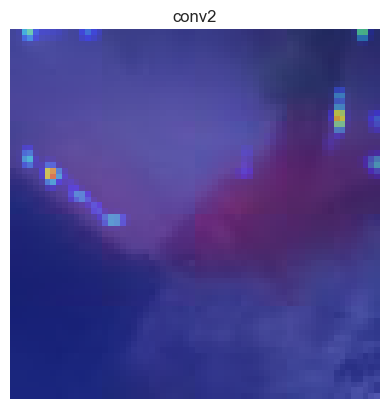

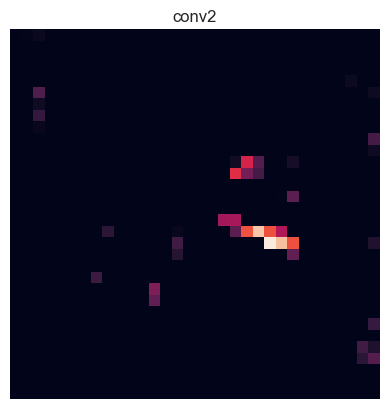

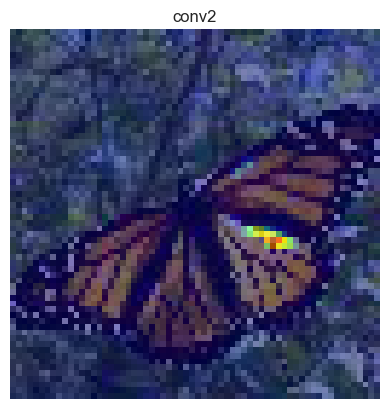

In [55]:
for i in path_list:
    show_cam(i)

#### 6.3 Your comments on :
> a) Why model predictions were correct or incorrect? You can support your case from 6.2

> b) What can you do to improve your results further?

---> Double click to respond here

**Please refer to the submission section at the top of this notebook to prepare your submission. Use our teams channel to seek any help!**
